In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
from scipy.stats import chi2_contingency
from helper import cramers_V
import sys
import pickle

In [2]:
datapath = 'data/original/pre-imputed/'
C1W1net_df = pd.read_csv(datapath + 'C1W1_network_preimputed.csv')
C2W1net_df = pd.read_csv(datapath + '221114/C2W1_network_preimputed.csv')
mappings_df = pd.read_csv(datapath + 'mappings.csv')

C1W1net_vars = list(C1W1net_df.columns)
C2W1net_vars = list(C2W1net_df.columns)
if C1W1net_vars == C2W1net_vars:    net_vars = C1W1net_vars

In [3]:
C1W1_NS_df = C1W1net_df.filter(regex='(?=NS)(?=^(?!NSD))')  # network-confide df
C1W1_ND_df = pd.concat([C1W1net_df['NSD1'], C1W1net_df.filter(regex='ND')], axis=1)  # network-drug df

confide_vars = list(C1W1_NS_df.columns)
drugnet_vars = list(C1W1_ND_df.columns)

len(net_vars) == len(confide_vars) + len(drugnet_vars)

True

## Peer Features Visualization

### C1W1: Confide

In [64]:
alters_dict = {}
alters = list(set([v[-1] for v in confide_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all alters: ['A','B','C',...]
for a in alters:
    alters_dict[a] = [v for v in confide_vars if v[-1] == a]

alters_dict['A']  # all variables related to alter 'A'

['NSX2A',
 'NSX3A',
 'NSX5A',
 'NSX7A',
 'NSX8A',
 'NSX9A',
 'NSX10A',
 'NSX11A',
 'NSX12A']

In [65]:
NSX5_vars = [f'NSX5{a}' for a in alters]
for v in NSX5_vars:
    col = C1W1_NS_df[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    C1W1_NS_df.at[idx, v] = 0  # children
        elif 15 <= i <= 24: C1W1_NS_df.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: C1W1_NS_df.at[idx, v] = 2  # adult
        elif i >= 65:       C1W1_NS_df.at[idx, v] = 3  # senior

In [5]:
labelings_NS = {
    'NSX2': 'How long person X has been someone that you could confide in',
    'NSX3': 'How often you hang out or spend time with person X',
    'NSX5': 'Age of person X',
    'NSX7': 'Level of education person X has finished to the best of your knowledge',
    'NSX8': 'Current employment status of person X to the best of your knowledge',
    'NSX9': 'Whether person X is a person you are comfortable using drugs around',
    'NSX10': 'How often you have used drugs with person X in the past 30 days',
    'NSX11': 'How often (you think) person X uses drugs in general',
    'NSX12': 'Relationship with person X'
}

In [6]:
cate_mappings_NS = {
    'NSX2A': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3A': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5A': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7A': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8A': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9A': {1: 'No', 2: 'Yes'},
    'NSX10A': {1: 'Never', 4: 'Less than once a month', 5: 'Once a month', 6: 'Once a week', 7: '2-6 times a week', 8: 'One time per day', 9: '2-3 times per day', 10: '4 or more times per day'},
    'NSX11A': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12A': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2B': {1: 'Less than 6 months', 48: '6 months to a year', 49: '1-2 years', 50: '3-5 years', 51: 'More than 5 years'},
    'NSX3B': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5B': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7B': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8B': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9B': {1: 'No', 2: 'Yes'},
    'NSX10B': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11B': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12B': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2C': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3C': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5C': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7C': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8C': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9C': {1: 'No', 2: 'Yes'},
    'NSX10C': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11C': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12C': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2D': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3D': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5D': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7D': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8D': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9D': {1: 'No', 2: 'Yes'},
    'NSX10D': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11D': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12D': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2E': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3E': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5E': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7E': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8E': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9E': {1: 'No', 2: 'Yes'},
    'NSX10E': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11E': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12E': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2F': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NSX3F': {1: 'Less than once a months', 4: 'Once a month', 5: 'Once a week', 6: 'Almost daily'},
    'NSX5F': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7F': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8F': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9F': {1: 'No', 2: 'Yes'},
    'NSX10F': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11F': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12F': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2G': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3G': {1: 'Less than once a months', 8: 'Once a month', 9: 'Once a week', 10: 'Almost daily'},
    'NSX5G': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7G': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8G': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9G': {1: 'No', 2: 'Yes'},
    'NSX10G': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11G': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12G': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2H': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3H': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5H': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7H': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8H': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9H': {1: 'No', 4: 'Yes'},
    'NSX10H': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11H': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12H': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NSX2I': {1: 'Less than 6 months', 4: '6 months to a year', 5: '1-2 years', 6: '3-5 years', 7: 'More than 5 years'},
    'NSX3I': {1: 'Less than once a months', 7: 'Once a month', 8: 'Once a week', 9: 'Almost daily'},
    'NSX5I': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NSX7I': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NSX8I': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NSX9I': {1: 'No', 2: 'Yes'},
    'NSX10I': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX11I': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NSX12I': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'}
}

Note for relationship vars NSX13:
- Variables NSX131_2, NSX132_3, NSX133_4 ask whether person x knows person x themselves, so discard them
- Pairs [NSX131_3, NSX132_2], [NSX132_4, NSX133_3], [NSX131_4, NSX133_2] ask whether person x knows y and whether person y knows x, still keep them for now

In [66]:
relatio_vars = [v for v in confide_vars if v[:5] == 'NSX13' and v[5:] not in ['1_2', '2_3', '3_4']]

n_nodes_list = []
n_edges_list = []
net_features_list = []
for index, row in C1W1_NS_df.iterrows():  # for each row i.e., participant
    n_nodes = 0
    net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_NS[v].values()} for v in cate_mappings_NS.keys()}  # nested dict, each key is a variable for the alters
    
    for a in alters:  # for each alter
        alter_info = [row[v] for v in alters_dict[a]]
        if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
            n_nodes += 1
            for v, val in zip(alters_dict[a], alter_info):  # for each piece of info from an alter
                if not np.isnan(val):
                    net_features[v[:-1]][cate_mappings_NS[v][val]] += 1

    net_features_list.append(net_features)
    n_nodes_list.append(n_nodes)

    relatio_info = [row[v] for v in relatio_vars]
    n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
    n_edges_list.append(n_edges)

In [186]:
net_features_list[1]  # all network features of a participant (a key for each feature)

{'NSX2': {'Less than 6 months': 0,
  '6 months to a year': 0,
  '1-2 years': 1,
  '3-5 years': 0,
  'More than 5 years': 2},
 'NSX3': {'Less than once a months': 0,
  'Once a month': 2,
  'Once a week': 0,
  'Almost daily': 1},
 'NSX5': {'Children (14 and below)': 0,
  'Youth (15 to 24)': 0,
  'Adult (25 to 64)': 3,
  'Senior (65 and above)': 0},
 'NSX7': {'Less than high school': 0,
  'High school degree': 0,
  'Some college': 1,
  '2 year degree': 1,
  '4 year degree': 1,
  'Graduate or professional school': 0,
  "Don't know": 0},
 'NSX8': {'Employed full-time': 3,
  'Employed part-time': 0,
  'Not employed': 0,
  'Others': 0,
  "Don't know": 0},
 'NSX9': {'No': 3, 'Yes': 0},
 'NSX10': {'Never': 3,
  'Less than once a month': 0,
  'Once a month': 0,
  'Once a week': 0,
  '2-6 times a week': 0,
  'One time per day': 0,
  '2-3 times per day': 0,
  '4 or more times per day': 0},
 'NSX11': {'Never': 3,
  'Less than once a month': 0,
  'Once a month': 0,
  'Once a week': 0,
  '2-6 times a

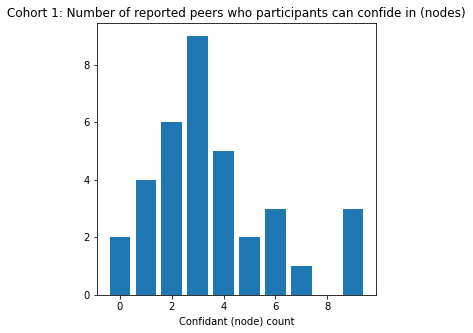

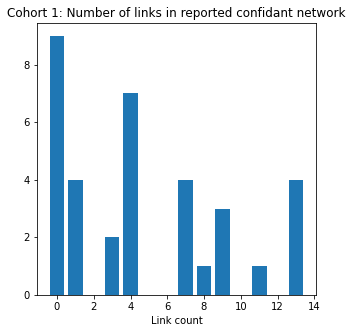

In [67]:
# Nodes
x = np.arange(max(n_nodes_list)+1)
heights = [n_nodes_list.count(i) for i in range(max(n_nodes_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 1: Number of reported peers who participants can confide in (nodes)')
plt.xlabel('Confidant (node) count')
plt.savefig(f'plots/analysis/C1-confide_net/C1-confide_net-nodes.pdf', facecolor='white', bbox_inches='tight')

# Edges
x = np.arange(max(n_edges_list)+1)
heights = [n_edges_list.count(i) for i in range(max(n_edges_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 1: Number of links in reported confidant network')
plt.xlabel('Link count')
plt.savefig(f'plots/analysis/C1-confide_net/C1-confide_net-edges.pdf', facecolor='white', bbox_inches='tight')

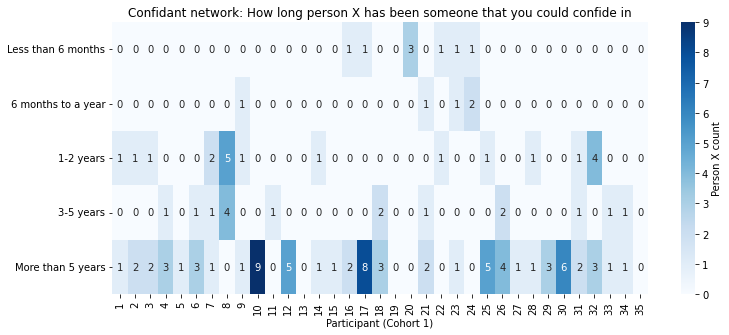

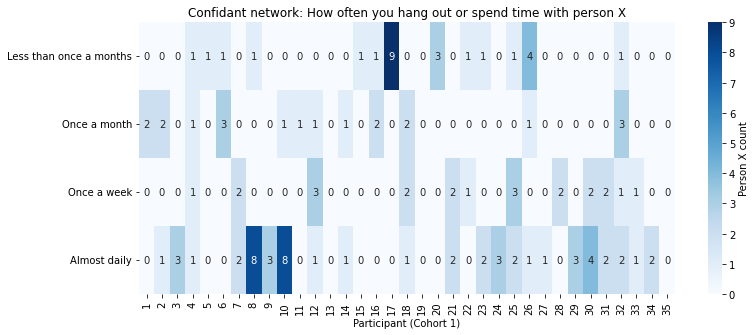

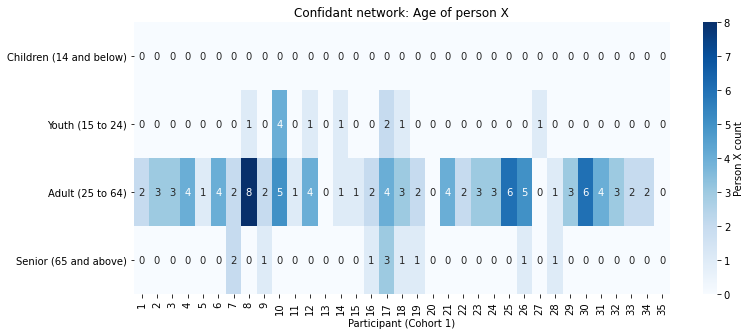

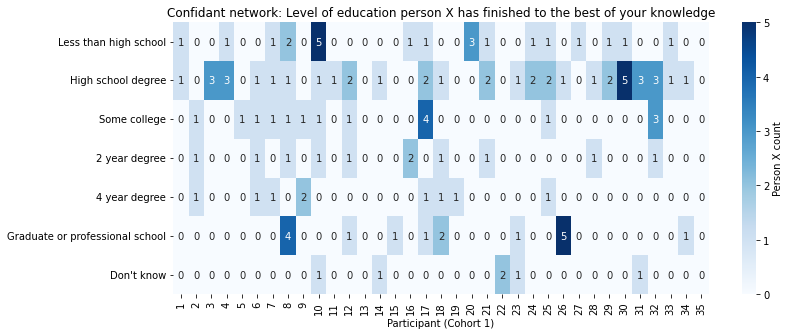

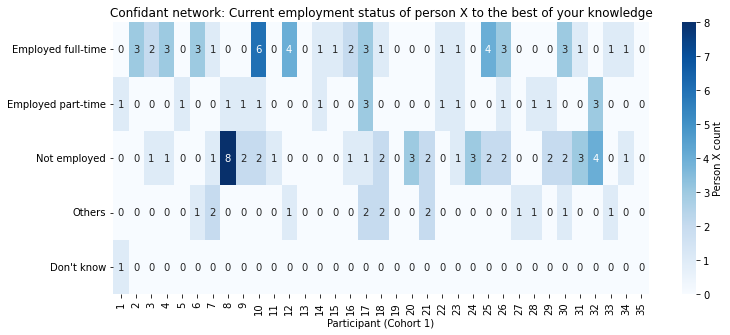

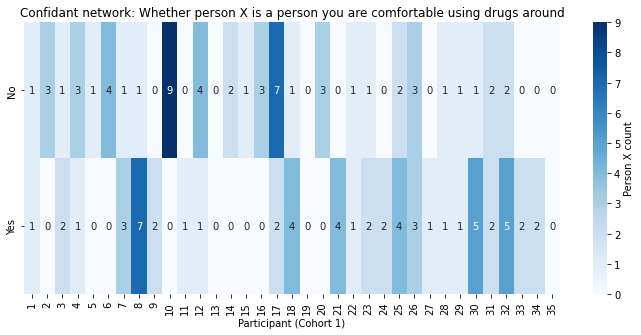

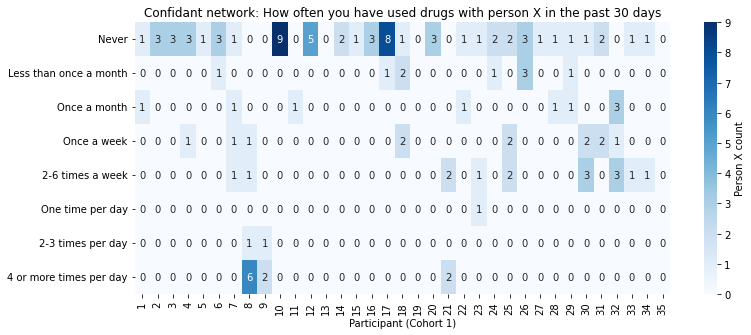

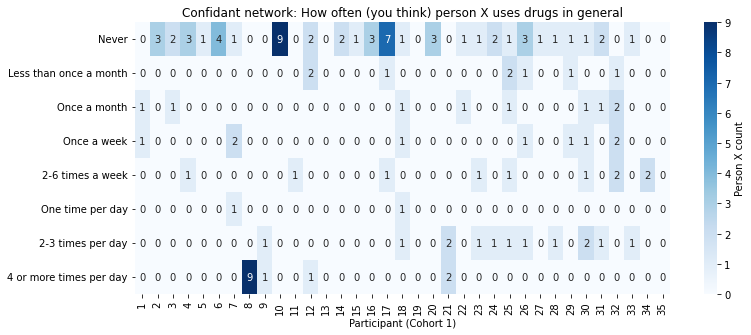

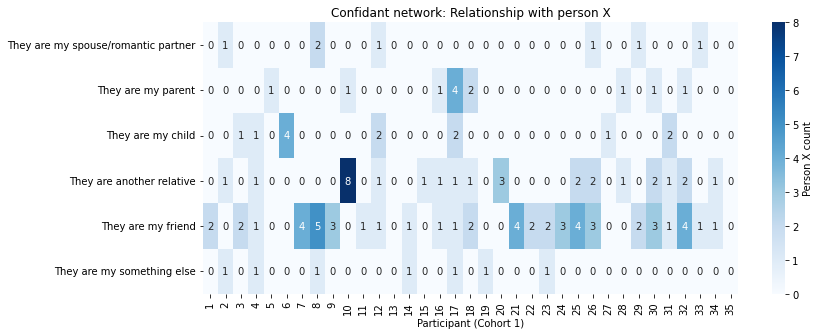

In [68]:
for v in net_features_list[0].keys():  # for each var

    info = {}
    for i, net_features in enumerate(net_features_list):  # for each participant
        info[i+1] = net_features[v]
    
    data = np.transpose([np.array(list(d.values())) for d in info.values()])

    plt.figure(figsize=(12,5))
    s = sns.heatmap(data, cmap='Blues', annot=True, xticklabels=np.arange(1,len(net_features_list)+1), yticklabels=cate_mappings_NS[v+'A'].values(),
                        cbar_kws={'label': 'Person X count'})
    s.set(xlabel='Participant (Cohort 1)', title=f'Confidant network: {labelings_NS[v]}')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.savefig(f'plots/analysis/C1-confide_net/C1-confide_net-{v}.pdf', facecolor='white', bbox_inches='tight')

### C1W1: Drug Net

In [90]:
alters_dict = {}
alters = list(set([v[-1] for v in drugnet_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all alters: ['J','K','L',...]
for a in alters:
    alters_dict[a] = [v for v in drugnet_vars if v[-1] == a]

alters_dict['J']  # all variables related to alter 'J'

['NDX2J', 'NDX4J', 'NDX5J', 'NDX6J', 'NDX8J', 'NDX9J', 'NDX12J']

In [91]:
NDX2_vars = [f'NDX2{a}' for a in alters]
for v in NDX2_vars:
    col = C1W1_ND_df[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    C1W1_ND_df.at[idx, v] = 0  # children
        elif 15 <= i <= 24: C1W1_ND_df.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: C1W1_ND_df.at[idx, v] = 2  # adult
        elif i >= 65:       C1W1_ND_df.at[idx, v] = 3  # senior

In [7]:
labelings_ND = {
    'NDX2': 'Age of person X',
    'NDX4': 'Level of education person X has finished to the best of your knowledge',
    'NDX5': 'Current employment status of person X to the best of your knowledge',
    'NDX6': 'Relationship with person X',
    'NDX8': 'How often you used drugs with person X in the past 30 days',
    'NDX9': 'How often (you think) person X uses drugs in general',
    'NDX12': 'How long you have used drugs with person X'
}

In [8]:
cate_mappings_ND = {
    'NDX2J': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4J': {1: 'Less than high school', 4: 'High school degree', 5: 'Some college', 6: '2 year degree', 7: '4 year degree', 8: 'Graduate or professional school', 9: "Don't know"},
    'NDX5J': {1: 'Employed full-time', 4: 'Employed part-time', 5: 'Not employed', 6: 'Others', 7: "Don't know"},
    'NDX6J': {1: 'They are my spouse/romantic partner', 4: 'They are my parent', 5: 'They are my child', 6: 'They are another relative', 7: 'They are my friend', 8: 'They are my something else'},
    'NDX8J': {11: 'Never', 12: 'Less than once a month', 13: 'Once a month', 14: 'Once a week', 15: '2-6 times a week', 16: 'One time per day', 17: '2-3 times per day', 18: '4 or more times per day'},
    'NDX9J': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX12J': {8: 'Less than 6 months', 9: '6 months to a year', 10: '1-2 years', 11: '3-5 years', 12: 'More than 5 years'},
    'NDX2K': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4K': {10: 'Less than high school', 11: 'High school degree', 12: 'Some college', 13: '2 year degree', 14: '4 year degree', 15: 'Graduate or professional school', 16: "Don't know"},
    'NDX5K': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6K': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 14: 'They are my something else'},
    'NDX8K': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX9K': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX12K': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2L': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4L': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5L': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6L': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8L': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX9L': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX12L': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2M': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4M': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5M': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others'},
    'NDX6M': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8M': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX9M': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 17: '2-3 times per day', 19: '4 or more times per day'},
    'NDX12M': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 12: '3-5 years', 15: 'More than 5 years'},
    'NDX2N': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4N': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5N': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6N': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8N': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX9N': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX12N': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2O': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4O': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5O': {1: 'Employed full-time', 9: 'Employed part-time', 10: 'Not employed', 11: 'Others', 12: "Don't know"},
    'NDX6O': {9: 'They are my spouse/romantic partner', 10: 'They are my parent', 11: 'They are my child', 12: 'They are another relative', 13: 'They are my friend', 14: 'They are my something else'},
    'NDX8O': {11: 'Never', 12: 'Less than once a month', 13: 'Once a month', 14: 'Once a week', 15: '2-6 times a week', 16: 'One time per day', 17: '2-3 times per day', 18: '4 or more times per day'},
    'NDX9O': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX12O': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2P': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4P': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5P': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6P': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8P': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX9P': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX12P': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2Q': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4Q': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5Q': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6Q': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8Q': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX9Q': {11: 'Never', 12: 'Less than once a month', 13: 'Once a month', 14: 'Once a week', 15: '2-6 times a week', 16: 'One time per day', 17: '2-3 times per day', 18: '4 or more times per day'},
    'NDX12Q': {1: 'Less than 6 months', 8: '6 months to a year', 9: '1-2 years', 10: '3-5 years', 11: 'More than 5 years'},
    'NDX2R': {0: 'Children (14 and below)', 1: 'Youth (15 to 24)', 2: 'Adult (25 to 64)', 3: 'Senior (65 and above)'},
    'NDX4R': {1: 'Less than high school', 10: 'High school degree', 11: 'Some college', 12: '2 year degree', 13: '4 year degree', 14: 'Graduate or professional school', 15: "Don't know"},
    'NDX5R': {1: 'Employed full-time', 8: 'Employed part-time', 9: 'Not employed', 10: 'Others', 11: "Don't know"},
    'NDX6R': {1: 'They are my spouse/romantic partner', 9: 'They are my parent', 10: 'They are my child', 11: 'They are another relative', 12: 'They are my friend', 13: 'They are my something else'},
    'NDX8R': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX9R': {1: 'Never', 11: 'Less than once a month', 12: 'Once a month', 13: 'Once a week', 14: '2-6 times a week', 15: 'One time per day', 16: '2-3 times per day', 17: '4 or more times per day'},
    'NDX12R': {1: 'Less than 6 months', 15: '6 months to a year', 16: '1-2 years', 17: '3-5 years', 18: 'More than 5 years'}
}

Note for relationship vars NDX15:
- Variables NDX151_2, NDX152_3, NDX153_4 ask whether person x knows person x themselves, so discard them
- Pairs [NDX151_3, NDX152_2], [NDX152_4, NDX153_3], [NDX151_4, NDX153_2] ask whether person x knows y and whether person y knows x, still keep them for now

In [92]:
relatio_vars = [v for v in drugnet_vars if v[:5] == 'NDX15' and v[5:] not in ['1_2', '2_3', '3_4']]

n_nodes_list = []
n_edges_list = []
net_features_list = []
for index, row in C1W1_ND_df.iterrows():  # for each row i.e., participant
    n_nodes = 0
    net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_ND[v].values()} for v in cate_mappings_ND.keys()}  # nested dict, each key is a variable for the alters
    
    for a in alters:  # for each alter
        alter_info = [row[v] for v in alters_dict[a]]
        if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
            n_nodes += 1
            for v, val in zip(alters_dict[a], alter_info):  # for each piece of info from an alter
                if not np.isnan(val):
                    net_features[v[:-1]][cate_mappings_ND[v][val]] += 1

    net_features_list.append(net_features)
    n_nodes_list.append(n_nodes)

    relatio_info = [row[v] for v in relatio_vars]
    n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
    n_edges_list.append(n_edges)

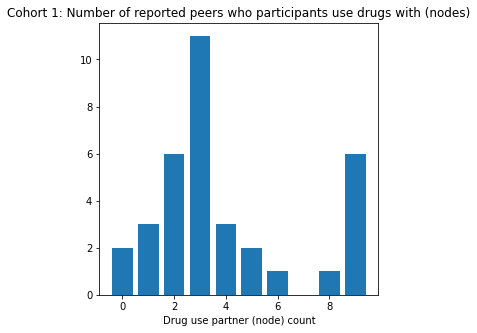

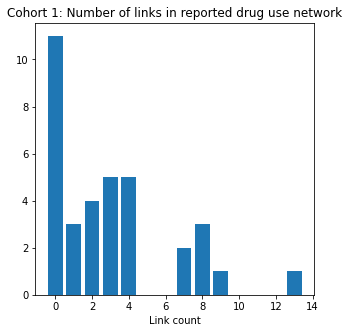

In [72]:
# Nodes
x = np.arange(max(n_nodes_list)+1)
heights = [n_nodes_list.count(i) for i in range(max(n_nodes_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 1: Number of reported peers who participants use drugs with (nodes)')
plt.xlabel('Drug use partner (node) count')
plt.savefig(f'plots/analysis/C1-drug_net/C1-drug_net-nodes.pdf', facecolor='white', bbox_inches='tight')

# Edges
x = np.arange(max(n_edges_list)+1)
heights = [n_edges_list.count(i) for i in range(max(n_edges_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 1: Number of links in reported drug use network')
plt.xlabel('Link count')
plt.savefig(f'plots/analysis/C1-drug_net/C1-drug_net-edges.pdf', facecolor='white', bbox_inches='tight')

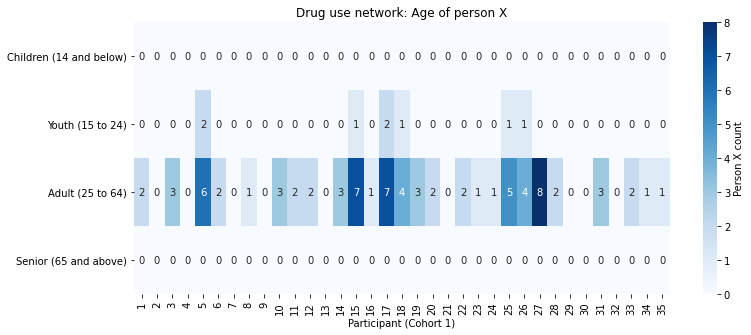

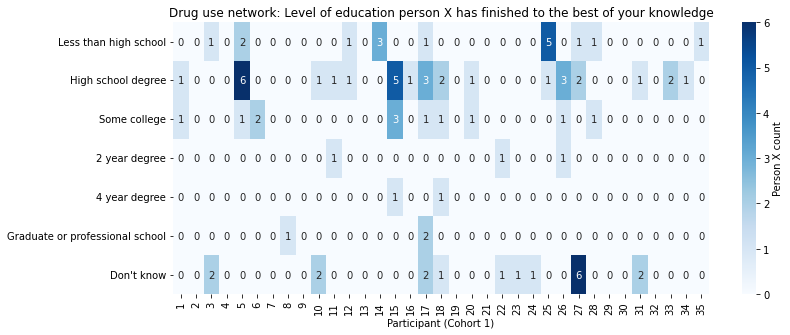

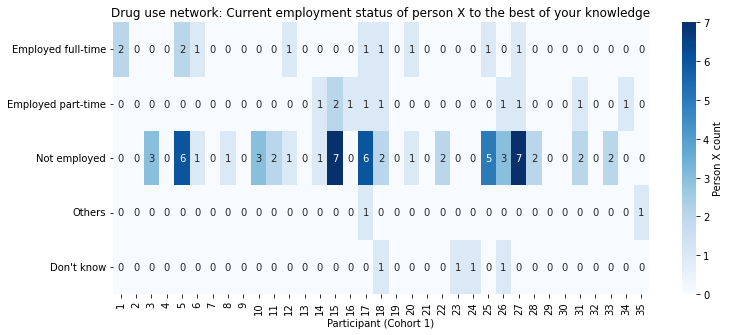

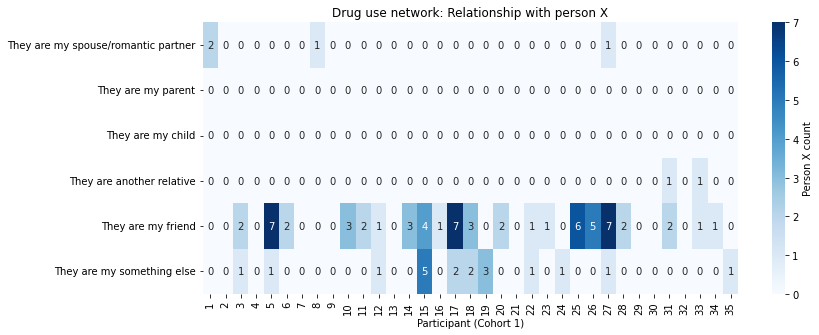

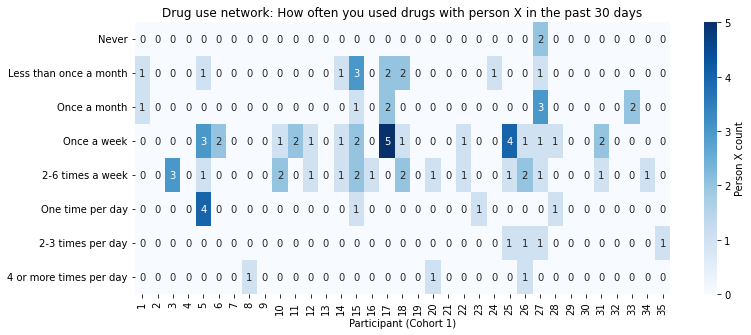

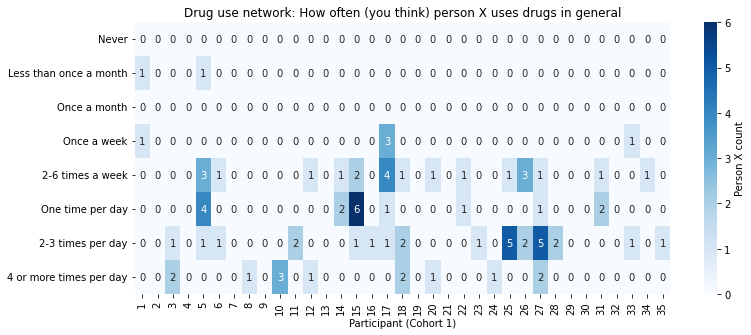

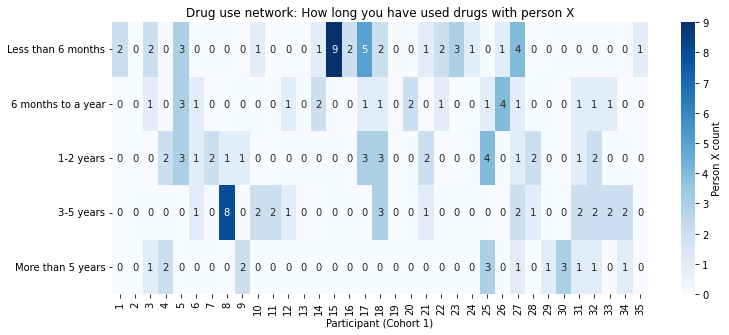

In [73]:
for v in net_features_list[0].keys():  # for each var

    info = {}
    for i, net_features in enumerate(net_features_list):  # for each participant
        info[i+1] = net_features[v]
    
    data = np.transpose([np.array(list(d.values())) for d in info.values()])

    plt.figure(figsize=(12,5))
    s = sns.heatmap(data, cmap='Blues', annot=True, xticklabels=np.arange(1,len(net_features_list)+1), yticklabels=cate_mappings_ND[v+'J'].values(),
                        cbar_kws={'label': 'Person X count'})
    s.set(xlabel='Participant (Cohort 1)', title=f'Drug use network: {labelings_ND[v]}')
    s.set_xticklabels(s.get_xticklabels(), rotation=90)
    plt.savefig(f'plots/analysis/C1-drug_net/C1-drug_net-{v}.pdf', facecolor='white', bbox_inches='tight')

### C2W1

#### Confide

In [4]:
C2W1_NS_df = C2W1net_df.filter(regex='(?=NS)(?=^(?!NSD))')  # network-confide df
C2W1_ND_df = pd.concat([C2W1net_df['NSD1'], C2W1net_df.filter(regex='ND')], axis=1)  # network-drug df

confide_vars = list(C2W1_NS_df.columns)
drugnet_vars = list(C2W1_ND_df.columns)

len(net_vars) == len(confide_vars) + len(drugnet_vars)

True

In [9]:
alters_dict = {}
alters = list(set([v[-1] for v in confide_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all alters: ['A','B','C',...]
for a in alters:
    alters_dict[a] = [v for v in confide_vars if v[-1] == a]

NSX5_vars = [f'NSX5{a}' for a in alters]
for v in NSX5_vars:
    col = C2W1_NS_df[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    C2W1_NS_df.at[idx, v] = 0  # children
        elif 15 <= i <= 24: C2W1_NS_df.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: C2W1_NS_df.at[idx, v] = 2  # adult
        elif i >= 65:       C2W1_NS_df.at[idx, v] = 3  # senior

In [10]:
relatio_vars = [v for v in confide_vars if v[:5] == 'NSX13' and v[5:] not in ['1_2', '2_3', '3_4']]

n_nodes_list = []
n_edges_list = []
net_features_list = []
for index, row in C2W1_NS_df.iterrows():  # for each row i.e., participant
    n_nodes = 0
    net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_NS[v].values()} for v in cate_mappings_NS.keys()}  # nested dict, each key is a variable for the alters
    
    for a in alters:  # for each alter
        alter_info = [row[v] for v in alters_dict[a]]
        if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
            n_nodes += 1
            for v, val in zip(alters_dict[a], alter_info):  # for each piece of info from an alter
                if not np.isnan(val):
                    net_features[v[:-1]][cate_mappings_NS[v][val]] += 1

    net_features_list.append(net_features)
    n_nodes_list.append(n_nodes)

    relatio_info = [row[v] for v in relatio_vars]
    n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
    n_edges_list.append(n_edges)

In [ ]:
# Nodes
x = np.arange(max(n_nodes_list)+1)
heights = [n_nodes_list.count(i) for i in range(max(n_nodes_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 2: Number of reported peers who participants can confide in (nodes)')
plt.xlabel('Confidant (node) count')
# plt.savefig(f'plots/analysis/C2-confide_net/C2-confide_net-nodes.pdf', facecolor='white', bbox_inches='tight')

# Edges
x = np.arange(max(n_edges_list)+1)
heights = [n_edges_list.count(i) for i in range(max(n_edges_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 2: Number of links in reported confidant network')
plt.xlabel('Link count')
# plt.savefig(f'plots/analysis/C2-confide_net/C2-confide_net-edges.pdf', facecolor='white', bbox_inches='tight')


for v in net_features_list[0].keys():  # for each var

    info = {}
    for i, net_features in enumerate(net_features_list):  # for each participant
        info[i+1] = net_features[v]
    
    data = np.transpose([np.array(list(d.values())) for d in info.values()])

    plt.figure(figsize=(25,5))
    s = sns.heatmap(data, cmap='Blues', annot=True, xticklabels=np.arange(1,len(net_features_list)+1), yticklabels=cate_mappings_NS[v+'A'].values(),
                        cbar_kws={'label': 'Person X count'})
    s.set(xlabel='Participant (Cohort 2)', title=f'Confidant network: {labelings_NS[v]}')
    # s.set_xticklabels(s.get_xticklabels(), rotation=0)
    # plt.savefig(f'plots/analysis/C2-confide_net/C2-confide_net-{v}.pdf', facecolor='white', bbox_inches='tight')

#### Drug Net

In [12]:
alters_dict = {}
alters = list(set([v[-1] for v in drugnet_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all alters: ['J','K','L',...]
for a in alters:
    alters_dict[a] = [v for v in drugnet_vars if v[-1] == a]

NDX2_vars = [f'NDX2{a}' for a in alters]
for v in NDX2_vars:
    col = C2W1_ND_df[v]
    for idx, i in enumerate(col):
        if 0 <= i <= 14:    C2W1_ND_df.at[idx, v] = 0  # children
        elif 15 <= i <= 24: C2W1_ND_df.at[idx, v] = 1  # youth
        elif 25 <= i <= 64: C2W1_ND_df.at[idx, v] = 2  # adult
        elif i >= 65:       C2W1_ND_df.at[idx, v] = 3  # senior

In [13]:
relatio_vars = [v for v in drugnet_vars if v[:5] == 'NDX15' and v[5:] not in ['1_2', '2_3', '3_4']]

n_nodes_list = []
n_edges_list = []
net_features_list = []
for index, row in C2W1_ND_df.iterrows():  # for each row i.e., participant
    n_nodes = 0
    net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_ND[v].values()} for v in cate_mappings_ND.keys()}  # nested dict, each key is a variable for the alters
    
    for a in alters:  # for each alter
        alter_info = [row[v] for v in alters_dict[a]]
        if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
            n_nodes += 1
            for v, val in zip(alters_dict[a], alter_info):  # for each piece of info from an alter
                if not np.isnan(val):
                    net_features[v[:-1]][cate_mappings_ND[v][val]] += 1

    net_features_list.append(net_features)
    n_nodes_list.append(n_nodes)

    relatio_info = [row[v] for v in relatio_vars]
    n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
    n_edges_list.append(n_edges)

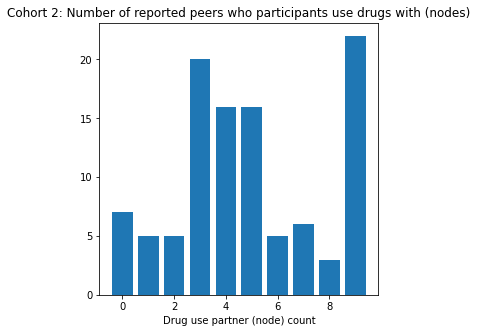

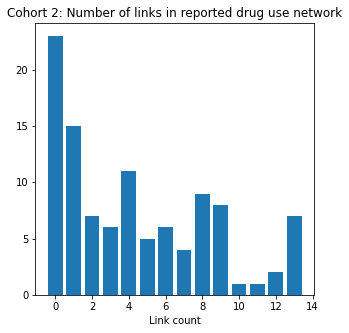

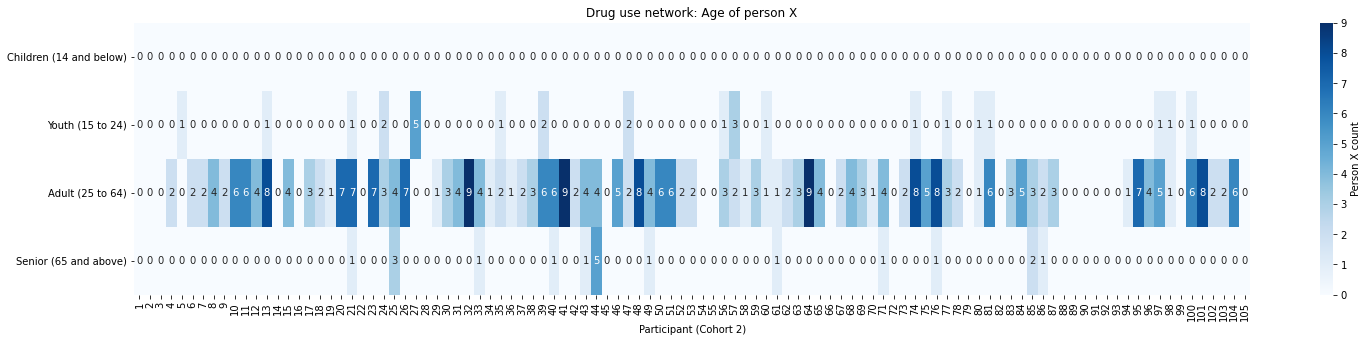

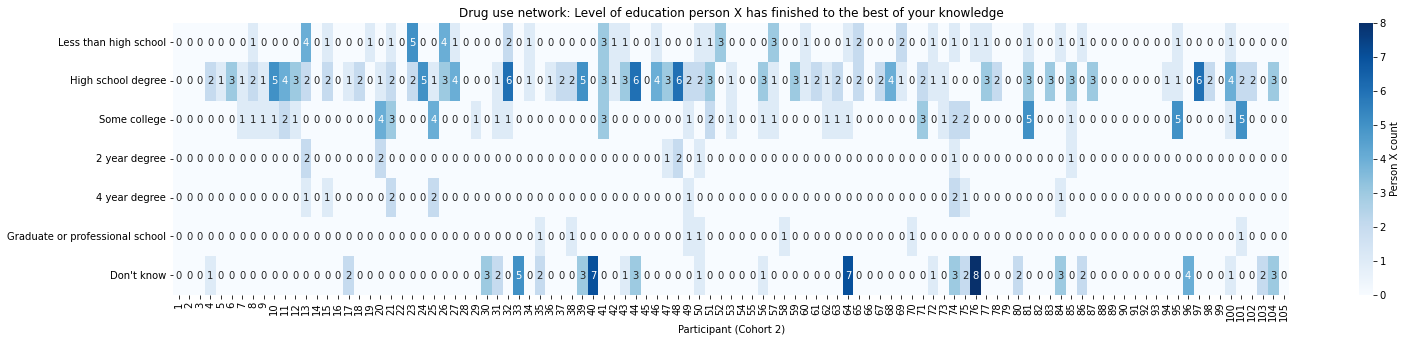

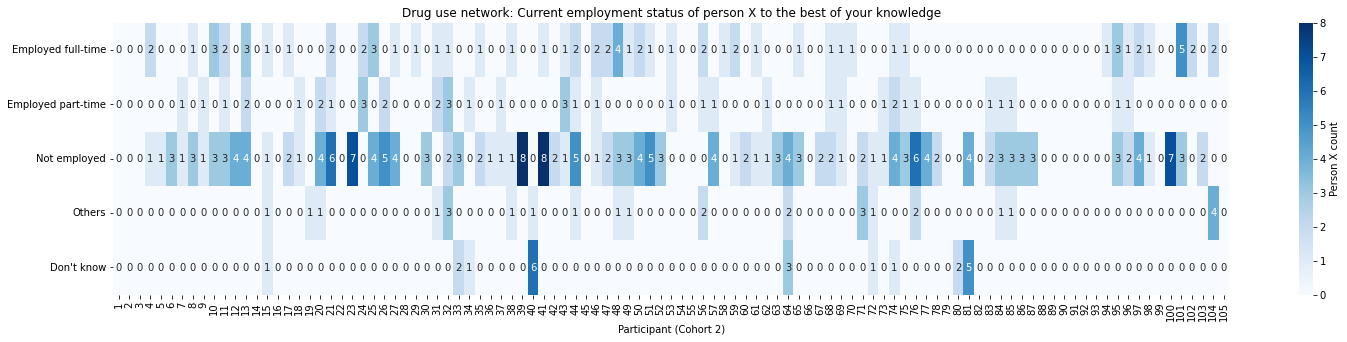

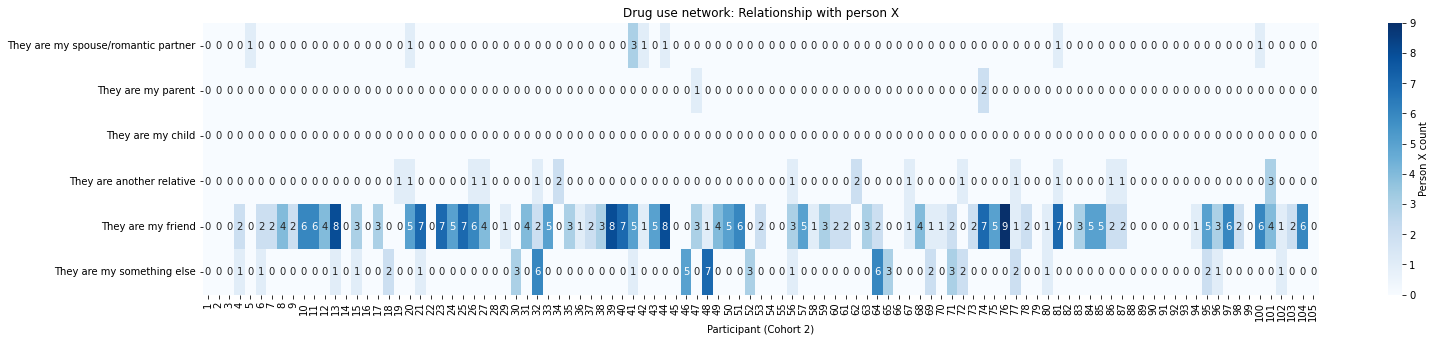

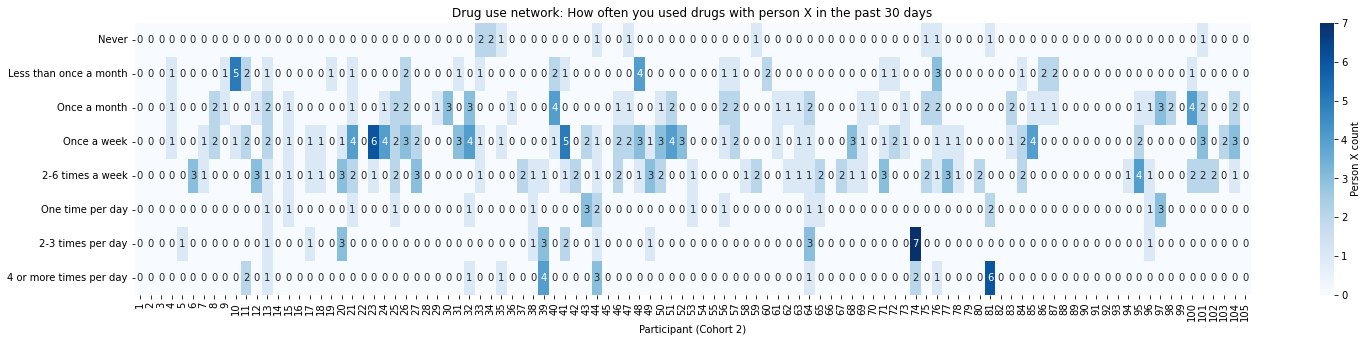

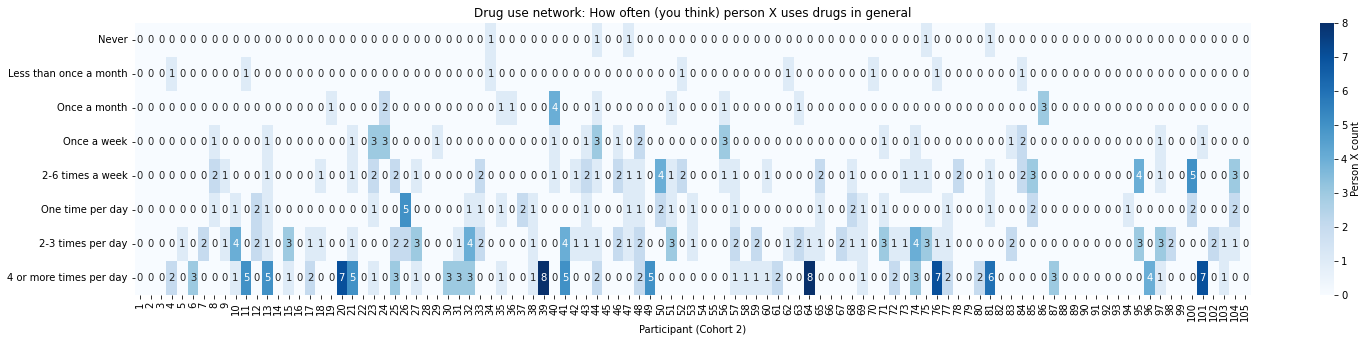

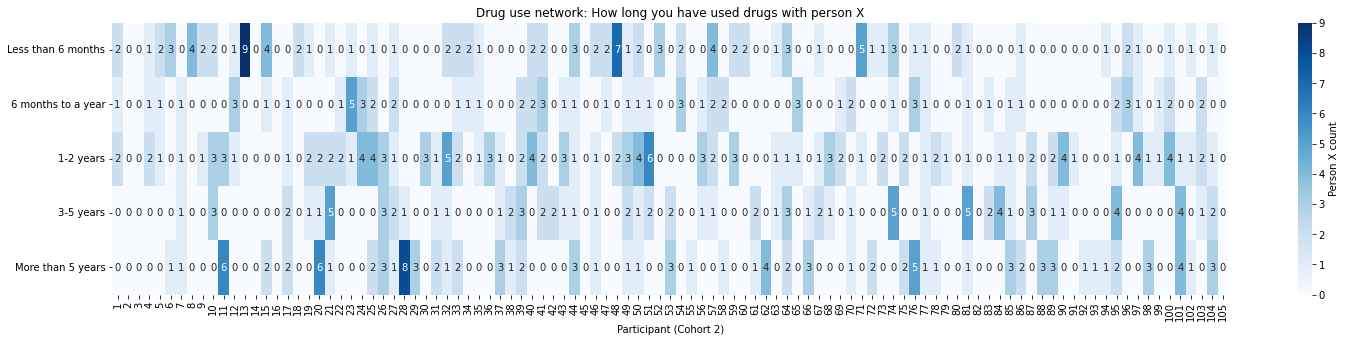

In [14]:
# Nodes
x = np.arange(max(n_nodes_list)+1)
heights = [n_nodes_list.count(i) for i in range(max(n_nodes_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 2: Number of reported peers who participants use drugs with (nodes)')
plt.xlabel('Drug use partner (node) count')
# plt.savefig(f'plots/analysis/C2-drug_net/C2-drug_net-nodes.pdf', facecolor='white', bbox_inches='tight')

# Edges
x = np.arange(max(n_edges_list)+1)
heights = [n_edges_list.count(i) for i in range(max(n_edges_list)+1)]
plt.figure(figsize=(5,5))
plt.bar(x, heights)
plt.title('Cohort 2: Number of links in reported drug use network')
plt.xlabel('Link count')
# plt.savefig(f'plots/analysis/C2-drug_net/C2-drug_net-edges.pdf', facecolor='white', bbox_inches='tight')


for v in net_features_list[0].keys():  # for each var

    info = {}
    for i, net_features in enumerate(net_features_list):  # for each participant
        info[i+1] = net_features[v]
    
    data = np.transpose([np.array(list(d.values())) for d in info.values()])

    plt.figure(figsize=(25,5))
    s = sns.heatmap(data, cmap='Blues', annot=True, xticklabels=np.arange(1,len(net_features_list)+1), yticklabels=cate_mappings_ND[v+'J'].values(),
                        cbar_kws={'label': 'Person X count'})
    s.set(xlabel='Participant (Cohort 2)', title=f'Drug use network: {labelings_ND[v]}')
    # s.set_xticklabels(s.get_xticklabels(), rotation=0)
    # plt.savefig(f'plots/analysis/C2-drug_net/C2-drug_net-{v}.pdf', facecolor='white', bbox_inches='tight')

## Correlations

### Exhaustively

For each variable, e.g., if it has 4 categories then split it into 4 sub-variables

In [18]:
datapath = 'data/original/pre-imputed/'
C1W1net_df = pd.read_csv(datapath + 'C1W1_network_preimputed.csv')
C2W1net_df = pd.read_csv(datapath + 'C2W1_network_preimputed.csv')

C1W1_NS_df = C1W1net_df.filter(regex='(?=NS)(?=^(?!NSD))')  # network-confide df
C1W1_ND_df = pd.concat([C1W1net_df['NSD1'], C1W1net_df.filter(regex='ND')], axis=1)  # network-drug df
C2W1_NS_df = C2W1net_df.filter(regex='(?=NS)(?=^(?!NSD))')  # network-confide df
C2W1_ND_df = pd.concat([C2W1net_df['NSD1'], C2W1net_df.filter(regex='ND')], axis=1)  # network-drug df

# same for both C1 and C2
confide_vars = list(C1W1_NS_df.columns)
drugnet_vars = list(C1W1_ND_df.columns)

C1pred_df = pd.read_csv(datapath + 'C1_nonnetwork_pred.csv')
C2pred_df = pd.read_csv(datapath + 'C2_nonnetwork_pred.csv')

In [5]:
def extract_net_info(cohort, NS_df, ND_df):

    alters_NS_dict = {}
    alters_NS = list(set([v[-1] for v in confide_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all NS alters: ['A','B','C',...]
    for a in alters_NS:
        alters_NS_dict[a] = [v for v in confide_vars if v[-1] == a]

    NSX5_vars = [f'NSX5{a}' for a in alters_NS]
    for v in NSX5_vars:
        col = NS_df[v]
        for idx, i in enumerate(col):
            if 0 <= i <= 14:    NS_df.at[idx, v] = 0  # children
            elif 15 <= i <= 24: NS_df.at[idx, v] = 1  # youth
            elif 25 <= i <= 64: NS_df.at[idx, v] = 2  # adult
            elif i >= 65:       NS_df.at[idx, v] = 3  # senior

    relatio_vars = [v for v in confide_vars if v[:5] == 'NSX13' and v[5:] not in ['1_2', '2_3', '3_4']]
    NS_features_list = []
    for index, row in NS_df.iterrows():  # for each row i.e., participant
        n_nodes = 0
        net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_NS[v].values()} for v in cate_mappings_NS.keys()}  # nested dict, each key is a variable for the alters
        
        for a in alters_NS:  # for each alter
            alter_info = [row[v] for v in alters_NS_dict[a]]
            if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
                n_nodes += 1
                for v, val in zip(alters_NS_dict[a], alter_info):  # for each piece of info from an alter
                    if not np.isnan(val):
                        net_features[v[:-1]][cate_mappings_NS[v][val]] += 1

        NS_features_list.append(net_features)
        NS_features_list[index]['n_nodes_NS'] = n_nodes

        relatio_info = [row[v] for v in relatio_vars]
        n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
        NS_features_list[index]['n_edges_NS'] = n_edges

    #----------------------------------------------------------------------------------------------------------------------------------

    alters_ND_dict = {}
    alters_ND = list(set([v[-1] for v in drugnet_vars if v[-1].isalpha() and v[-4:] != 'TEXT']))  # all ND alters: ['J','K','L',...]
    for a in alters_ND:
        alters_ND_dict[a] = [v for v in drugnet_vars if v[-1] == a]

    NDX2_vars = [f'NDX2{a}' for a in alters_ND]
    for v in NDX2_vars:
        col = ND_df[v]
        for idx, i in enumerate(col):
            if 0 <= i <= 14:    ND_df.at[idx, v] = 0  # children
            elif 15 <= i <= 24: ND_df.at[idx, v] = 1  # youth
            elif 25 <= i <= 64: ND_df.at[idx, v] = 2  # adult
            elif i >= 65:       ND_df.at[idx, v] = 3  # senior

    relatio_vars = [v for v in drugnet_vars if v[:5] == 'NDX15' and v[5:] not in ['1_2', '2_3', '3_4']]
    ND_features_list = []
    for index, row in ND_df.iterrows():  # for each row i.e., participant
        n_nodes = 0
        net_features = {v[:-1]: {cate: 0 for cate in cate_mappings_ND[v].values()} for v in cate_mappings_ND.keys()}  # nested dict, each key is a variable for the alters
        
        for a in alters_ND:  # for each alter
            alter_info = [row[v] for v in alters_ND_dict[a]]
            if not np.isnan(alter_info).all():  # node exists if info of alter is not all nan
                n_nodes += 1
                for v, val in zip(alters_ND_dict[a], alter_info):  # for each piece of info from an alter
                    if not np.isnan(val):
                        net_features[v[:-1]][cate_mappings_ND[v][val]] += 1

        ND_features_list.append(net_features)
        ND_features_list[index]['n_nodes_ND'] = n_nodes

        relatio_info = [row[v] for v in relatio_vars]
        n_edges = relatio_info.count(2)  # categorical value 2 means person x knows person y --> edge (x,y) exists
        ND_features_list[index]['n_edges_ND'] = n_edges

    #----------------------------------------------------------------------------------------------------------------------------------
    return NS_features_list, ND_features_list


In [ ]:
for cohort in range(1,3):

    if cohort == 1:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C1W1_NS_df, ND_df=C1W1_ND_df)
        markersize = 30
        pws = [1, 2, 5, 10]
    else:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C2W1_NS_df, ND_df=C2W1_ND_df)
        markersize = 20
        pws = [1, 5, 10, 20]
    '''
    Dataframe where each column is the features e.g., NSX2_x where x is the category (if NSX2 has 4 categories than x in [1,4])
    '''
    NS_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_NS'], i_info['n_edges_NS']] for i_info in NS_features_list],
        columns=[f'{v}_{cate}' for v in NS_features_list[0].keys() if not v.startswith('n_') for cate in NS_features_list[0][v].keys()]+['n_nodes_NS','n_edges_NS']
    )
    ND_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_ND'], i_info['n_edges_ND']] for i_info in ND_features_list],
        columns=[f'{v}_{cate}' for v in ND_features_list[0].keys() if not v.startswith('n_') for cate in ND_features_list[0][v].keys()]+['n_nodes_ND','n_edges_ND']
    )

    for drug in ['marijuana', 'meth']:
        
        if cohort == 1:
            df_pred = C1pred_df
            pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
        elif cohort == 2:
            df_pred = C2pred_df
            pred_var = zip(df_pred['ND1'], df_pred['W2_ND1']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['W2_ND7'])
        
        dep_var_full = []
        for a, b in pred_var:
            if not np.isnan(a) and not np.isnan(b):
                y = 'No' if a <= b else 'Yes'
                # y = a - b
                dep_var_full.append(y)
            else:   dep_var_full.append(np.nan)

        for netname, df in {'confidant network': NS_df, 'drug use network': ND_df}.items():

            indep_vars = list(df.columns)
            i = 0
            for v in indep_vars:

                indep_var = df[v]
                nonan_df = pd.DataFrame({'indep': list(indep_var), 'dep': dep_var_full}).dropna(axis=0)  # remove rows with nan in either column
                indep_var, dep_var = list(nonan_df['indep']), list(nonan_df['dep'])
                dep_var = [x for _, x in sorted(zip(indep_var, dep_var))]

                if not v.startswith('n_'):
                    i += 1                    
                    labelings = labelings_NS if v[:3] == 'NSX' else labelings_ND
                    ytitle = f"{labelings[v.split('_')[0]]}: {v.split('_')[1]}"
                    title = f'Cohort {cohort}: Correlation between number of peer count for variable and {drug} usage across 2 waves'
                    filename = f"plots/analysis/C{cohort}-{drug}/net/C{cohort}-{drug}-{v.split('_')[0]}_{i}.pdf"
                else:
                    ytitle = f"Number of {v.split('_')[1]} in reported {netname}"
                    title = f"Cohort {cohort}: Correlation between number of {v.split('_')[1]} and {drug} usage across 2 waves"
                    filename = f"plots/analysis/C{cohort}-{drug}/net/C{cohort}-{drug}-{v}-{netname}.pdf"

                if len(ytitle) > 40:     ytitle = '-\n'.join(ytitle[j:j+40] for j in range(0,len(ytitle), 40))  # break line if y title too long

                fig = plt.figure(figsize=(5, 5))
                ax = plt.figure().gca()

                c = Counter(zip(indep_var,dep_var))
                s = [markersize*c[(xx,yy)] for xx,yy in zip(indep_var,dep_var)]

                plt.scatter(dep_var, indep_var, s=s)  # only plot a point when both x and y non nan
                plt.ylabel(ytitle)
                plt.xlabel(f'Whether increase {drug} use in wave 2')
                plt.title(title)
                plt.xlim(-1, 2)
                ax.yaxis.get_major_locator().set_params(integer=True)
                #make a legend:
                for pw in pws:
                    plt.scatter([], [], s=pw*markersize, c="C0",label=str(pw))

                h, l = plt.gca().get_legend_handles_labels()
                plt.legend(h, l, labelspacing=1.2, title="count", borderpad=1, 
                            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w", loc='lower right')

                plt.savefig(filename, facecolor='white', bbox_inches='tight')
                plt.close(fig)

### Cramer's V and Chi2 test

Cramer's V

In [17]:
for cohort in range(1,3):

    if cohort == 1:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C1W1_NS_df, ND_df=C1W1_ND_df)
    else:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C2W1_NS_df, ND_df=C2W1_ND_df)

    NS_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_NS'], i_info['n_edges_NS']] for i_info in NS_features_list],
        columns=[f'{v}_{i+1}' for v in NS_features_list[0].keys() if not v.startswith('n_') for i in range(len(NS_features_list[0][v].keys()))]+['n_nodes_NS','n_edges_NS']
    )
    ND_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_ND'], i_info['n_edges_ND']] for i_info in ND_features_list],
        columns=[f'{v}_{i+1}' for v in ND_features_list[0].keys() if not v.startswith('n_') for i in range(len(ND_features_list[0][v].keys()))]+['n_nodes_ND','n_edges_ND']
    )
    df = pd.concat([NS_df, ND_df], axis=1)
    # df.to_csv(f'saved-vars/C{cohort}_network-processed.csv', index=False)

    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            df_pred = C1pred_df
            pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
        elif cohort == 2:
            df_pred = C2pred_df
            pred_var = zip(df_pred['ND1'], df_pred['W2_ND1']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['W2_ND7'])
        
        dep_var = []
        for a, b in pred_var:
            y = 0 if a <= b else 1
            # y = a - b
            dep_var.append(y)

        indep_vars = list(df.columns)
        corrs = []
        corrs_dict = {}
        for v in indep_vars:
            indep_var = df[v]
            corr, err_flag = cramers_V(pd.crosstab(df[v], dep_var).to_numpy())
            if err_flag:    print(f'Division of zero during CramersV calculation at variable {v}, Cohort {str(cohort)}, {drug}')
            corrs.append(corr)
            corrs_dict[v] = corr
        # with open(f'saved-vars/C{cohort}-{drug}-net_CramersV.pkl', 'wb') as file:
        #     pickle.dump(corrs_dict, file)

        fig = plt.figure(figsize=(10, 20))
        plt.barh([v.replace('_', '-') for v in indep_vars], corrs)
        plt.margins(y=0)
        plt.grid(True,axis='x')
        plt.title(f"Cohort {str(cohort)}: Cramer's V correlation between each variable and {drug} usage across 2 waves")
        plt.xlabel("Cramer's V index (in [0, 1], higher is more correlated)")
        plt.savefig(f'plots/analysis/C{str(cohort)}-{drug}/net/C{str(cohort)}-{drug}_CramersV.pdf', facecolor='white')

Chi-square test

In [ ]:
sig_level = 0.05
for cohort in range(1,3):

    if cohort == 1:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C1W1_NS_df, ND_df=C1W1_ND_df)
    else:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C2W1_NS_df, ND_df=C2W1_ND_df)

    NS_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_NS'], i_info['n_edges_NS']] for i_info in NS_features_list],
        columns=[f'{v}_{i+1}' for v in NS_features_list[0].keys() if not v.startswith('n_') for i in range(len(NS_features_list[0][v].keys()))]+['n_nodes_NS','n_edges_NS']
    )
    ND_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_ND'], i_info['n_edges_ND']] for i_info in ND_features_list],
        columns=[f'{v}_{i+1}' for v in ND_features_list[0].keys() if not v.startswith('n_') for i in range(len(ND_features_list[0][v].keys()))]+['n_nodes_ND','n_edges_ND']
    )
    df = pd.concat([NS_df, ND_df], axis=1)

    for drug in ['marijuana', 'meth']:

        if cohort == 1:
            df_pred = C1pred_df
            pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])
        elif cohort == 2:
            df_pred = C2pred_df
            pred_var = zip(df_pred['ND1'], df_pred['W2_ND1']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['W2_ND7'])
        
        dep_var = []
        for a, b in pred_var:
            y = 0 if a <= b else 1
            # y = a - b
            dep_var.append(y)

        indep_vars = list(df.columns)
        corrs = []
        for v in indep_vars:
            indep_var = df[v]
            chi2, p, dof = chi2_contingency(pd.crosstab(df[v], dep_var).to_numpy())[:3]
            corrs.append(p)

        fig = plt.figure(figsize=(10, 20))
        plt.barh([v.replace('_', '-') for v in indep_vars], corrs, label=None)
        plt.axvline(x=sig_level, color='r', label=f'significant level: {sig_level}')
        plt.margins(y=0)
        plt.grid(True,axis='x')
        plt.title(f"Cohort {str(cohort)}: Chi-square test's p-value between each variable and {drug} usage across 2 waves")
        plt.xlabel("p-value of the test (lower is more correlated)")
        plt.xlim([0,1])
        plt.legend()
        plt.savefig(f'plots/analysis/C{str(cohort)}-{drug}/net/C{str(cohort)}-{drug}_chi2test.pdf', facecolor='white')

Combine 2 cohorts

In [19]:
df = pd.DataFrame()

for cohort in range(1,3):

    if cohort == 1:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C1W1_NS_df, ND_df=C1W1_ND_df)
    else:
        NS_features_list, ND_features_list = extract_net_info(cohort, NS_df=C2W1_NS_df, ND_df=C2W1_ND_df)

    NS_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_NS'], i_info['n_edges_NS']] for i_info in NS_features_list],
        columns=[f'{v}_{i+1}' for v in NS_features_list[0].keys() if not v.startswith('n_') for i in range(len(NS_features_list[0][v].keys()))]+['n_nodes_NS','n_edges_NS']
    )
    ND_df = pd.DataFrame(
        [[i_info[v][cate] for v in i_info.keys() if not v.startswith('n_') for cate in i_info[v].keys()] + [i_info['n_nodes_ND'], i_info['n_edges_ND']] for i_info in ND_features_list],
        columns=[f'{v}_{i+1}' for v in ND_features_list[0].keys() if not v.startswith('n_') for i in range(len(ND_features_list[0][v].keys()))]+['n_nodes_ND','n_edges_ND']
    )

    if df.empty:
        df = pd.concat([NS_df, ND_df], axis=1)
    else:
        df = pd.concat([df, pd.concat([NS_df, ND_df], axis=1)], ignore_index=True)
    # df.to_csv(f'saved-vars/C12_network-processed.csv', index=False)

for drug in ['marijuana', 'meth']:
    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])

    dep_var = []
    for a, b in pred_var:
        y = 0 if a <= b else 1
        # y = a - b
        dep_var.append(y)

    indep_vars = list(df.columns)
    corrs = []
    corrs_dict = {}
    for v in indep_vars:
        indep_var = df[v]
        corr, err_flag = cramers_V(pd.crosstab(df[v], dep_var).to_numpy())
        # if err_flag:    print(f'Division of zero during CramersV calculation at variable {v}, Cohort {str(cohort)}, {drug}')
        corrs.append(corr)
        corrs_dict[v] = corr
    # with open(f'saved-vars/C12-{drug}-net_CramersV.pkl', 'wb') as file:
    #     pickle.dump(corrs_dict, file)

    fig = plt.figure(figsize=(10, 20))
    plt.barh([v.replace('_', '-') for v in indep_vars], corrs)
    plt.margins(y=0)
    plt.grid(True,axis='x')
    plt.title(f"Cohort 1+2: Cramer's V correlation between each variable and {drug} usage across 2 waves")
    plt.xlabel("Cramer's V index (in [0, 1], higher is more correlated)")
    plt.savefig(f'plots/analysis/C1-{drug}/net/C12-{drug}_CramersV.pdf', facecolor='white')


In [ ]:
#------------------------------------------------------------------------------------------------------------------------------------------------
sig_level = 0.05
for drug in ['marijuana', 'meth']:
    colname_map = {}
    C2pred_keys = list(C2pred_df.columns)
    for i, c in enumerate(list(C1pred_df.columns)):  # map column names of C2pred_df to C1pred_df (since C1W2 has different varnames)
        colname_map[C2pred_keys[i]] = c

    df_pred = pd.concat([C1pred_df, C2pred_df.rename(columns=colname_map)], ignore_index=True)
    pred_var = zip(df_pred['ND1'], df_pred['Q68']) if drug == 'marijuana' else zip(df_pred['ND7'], df_pred['Q75'])

    dep_var = []
    for a, b in pred_var:
        y = 0 if a <= b else 1
        # y = a - b
        dep_var.append(y)

    indep_vars = list(df.columns)
    corrs = []
    corrs_dict = {}
    for v in indep_vars:
        indep_var = df[v]
        corr, err_flag = cramers_V(pd.crosstab(df[v], dep_var).to_numpy())
        # if err_flag:    print(f'Division of zero during CramersV calculation at variable {v}, Cohort {str(cohort)}, {drug}')
        corrs.append(corr)
        corrs_dict[v] = corr

    fig = plt.figure(figsize=(10, 20))
    plt.barh([v.replace('_', '-') for v in indep_vars], corrs, label=None)
    plt.axvline(x=sig_level, color='r', label=f'significant level: {sig_level}')
    plt.margins(y=0)
    plt.grid(True,axis='x')
    plt.title(f"Cohort 1+2: Chi-square test's p-value between each variable and {drug} usage across 2 waves")
    plt.xlabel("p-value of the test (lower is more correlated)")
    plt.xlim([0,1])
    plt.legend()
    plt.savefig(f'plots/analysis/C1-{drug}/net/C12-{drug}_chi2test.pdf', facecolor='white')
    